In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torchvision
from IPython import display



In [41]:
from typing import Tuple, List, Optional
ImageType = torch.Tensor
TensorType = torch.Tensor
AxesType = matplotlib.axes.Axes
FigureType = matplotlib.figure.Figure

Invariance to local translation can be a very useful property if we care more about whether some feature is present than exactly where it is. For example, when determining whether an image contains a face, we need not know the location of the eyes with pixel-perfect accuracy, we just need to know that there is an eye on the left side of the face and an eye on the right side of the face.

— Page 342, Deep Learning, 2016.


[אתר מדהים שממחיש את בעזרת קונבלוציה ניתן לעבד תמונות](https://setosa.io/ev/image-kernels/)

Our goal is to find out how gradient is propagating backwards in a convolutional layer. The forward pass is defined like this:

The input consists of N data points, each with C channels, height H and width W. We convolve each input with F different filters, where each filter spans all C channels and has height HH and width WW.

Input:

    x: Input data of shape (N, C, H, W)
    w: Filter weights of shape (F, C, HH, WW)
    b: Biases, of shape (F,)
    conv_param: A dictionary with the following keys:
    ‘stride’: The number of pixels between adjacent receptive fields in the horizontal and vertical directions.
    ‘pad’: The number of pixels that will be used to zero-pad the input.

During padding, ‘pad’ zeros should be placed symmetrically (i.e equally on both sides) along the height and width axes of the input.

Returns a tuple of:

    out: Output data, of shape (N, F, H’, W’) where H’ and W’ are given by

H’ = 1 + (H + 2 * pad — HH) / stride

W’ = 1 + (W + 2 * pad — WW) / stride

    cache: (x, w, b, conv_param)

<div dir="rtl" lang="he" xml:lang="he">

## שימוש בפונקציית קונבלוציה
פונקציית קונבלוציה מאפשרת לנו למצוא תבניות בתוך התמונות, בהדגמה להלן נראה איך פונקציית קונבלוציה יכולה למצוא תבנית מסויימת בתוך תמונה

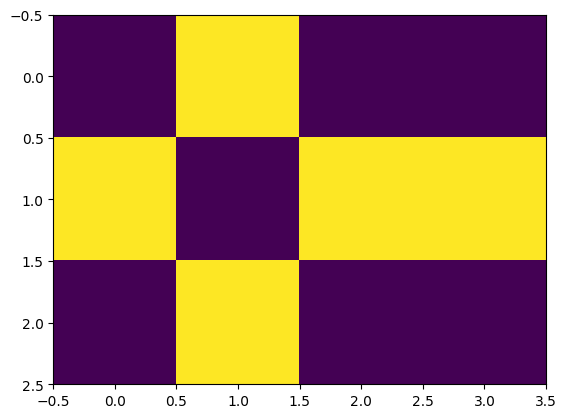

In [42]:
pattern = torch.tensor([[0, 1, 0, 0], [1, 0, 1, 1], [0, 1, 0, 0]], dtype=torch.float32)
plt.imshow(pattern)


<div dir="rtl" lang="he" xml:lang="he">

## זהוי התבנית בתוך תמונה מורעשת
ניצור תמונה עם תבנית כל שהיא במקומות אקראיים, ונראה איך פונקציית הקונבולוציה יכולה למצוא את המקום שלהם 

התמונות העוברת לפונקציית הקונבלוציה הם תמיד מהצורה הבאה:
`מספר נקודות`X`מספר ערוצים`X`גובה`X`רוחב` 

 במה שנעשה כעת נשתמש רק בערוץ אחד ובנקודה 
 לכן המימד של התמונה שלנו הוא `1,1,100,100`
 

In [68]:
import random


def add_shape(image: ImageType, i: int, j: int, pattern=pattern) -> ImageType:
    """
    Adds a pattern to an image at a specified location.
    Args:
        image: A tensor representing the image to add the pattern to.
        i: An integer representing the row index to start adding the pattern.
        j: An integer representing the column index to start adding the pattern.
        pattern: A tensor representing the pattern to add to the image.

    Returns:
        The modified image tensor.
    """
    f_li, f_lj = pattern.shape
    assert i + f_li <= image.shape[0]
    assert j + f_lj <= image.shape[1]
    image[i : i + f_li, j : j + f_lj] = pattern
    return image


def add_multiply_shapes(
    image: ImageType, pattern: ImageType, n: int = 30
) -> TensorType:
    """
    Adds multiple instances of a pattern to an image at random locations.
    Args:
        image: A tensor representing the image to add the patterns to.
        pattern: A tensor representing the pattern to add to the image.
        n: An integer representing the number of times to add the pattern to the image.

    Returns:
        A tensor representing the locations where the patterns were added.
    """
    locations = torch.empty(n, 2)
    range_pixels = min(
        image.shape[0] - pattern.shape[0], image.shape[1] - pattern.shape[1]
    )
    for ind in range(n):
        i = random.randint(0, range_pixels)
        j = random.randint(0, range_pixels)
        # locations[ind] = torch.tensor((i, j))
        # if random.choice([0, 1]):
        #     add_shape(image, i, j, pattern=pattern)
        # else:
        # add_shape(image, i, j, pattern=pattern.T)
        add_shape(image, i, j, pattern=pattern)
    return locations


def annotated_heatmaps(image: ImageType, axes: Optional[AxesType] = None):
    """
    Displays an annotated heatmap of an image.
    Args:
        image: A tensor representing the image to display.
        axes: An optional Axes object to display the heatmap on. If None, a new figure will be created.

    Returns:
        None
    """
    assert image.dim() >= 2, "image.dim() most should be 2 or more"
    axes = axes if axes else plt.axes()

    flattened_image = image.view(
        *image.size()[-1:], -1
    )  # flatten image to last 2 dimensions
    im = axes.imshow(flattened_image)
    im.figure.colorbar(im, ax=axes)
    height = flattened_image.size()[0]
    width = flattened_image.size()[1]
    for row in range(height):
        for col in range(width):
            axes.text(
                col,
                row,
                f"{flattened_image[row,col]:.3}",
                ha="center",
                va="center",
                color="w",
            )


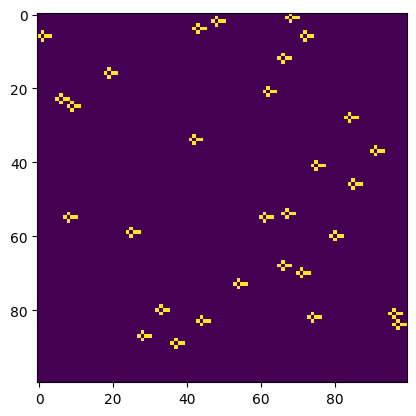

In [16]:
image = torch.zeros(1,1,100,100)
add_multiply_shapes(image[0,0,:,:], pattern)
plt.imshow(image[0,0,:,:])

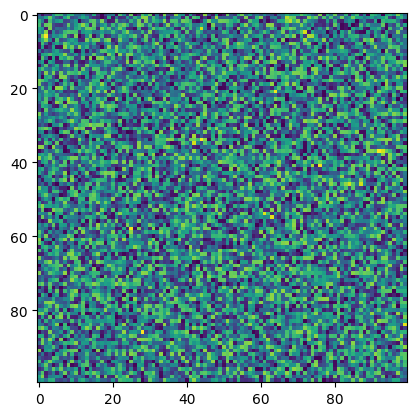

In [17]:
## create 2d noise image
noise = torch.empty(100,100).uniform_(0,5)
dirty_im  = image.clone()
dirty_im[0,0,:,:] += noise
plt.imshow(dirty_im[0,0,:,:])

<div dir="rtl" lang="he" xml:lang="he">

## מפת תכונות _feature map_
פונקציית הקונבולוציה מוציאה מפה פיצ'רים , לאחר הפעלת הפילטר.אחד השימושים הוא למצוא תבניות בתמונה, במקרה שלנו ננסה למצוא תבנית ספציפית שנמצאת בתמונה

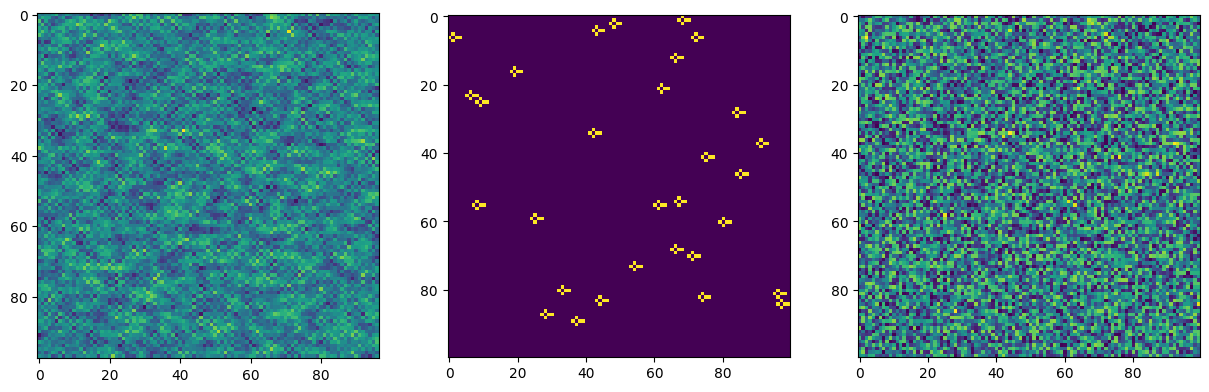

In [18]:
pattern.unsqueeze_(0).unsqueeze_(0) # make the figure 4D
feature_map = torch.conv2d(dirty_im,pattern)

#display it
fig,(axis_feature_map,axis_source_image,axis_dirty_im) = plt.subplots(1,3,figsize=(15,5))
axis_feature_map.imshow(feature_map[0,0,:,:])
axis_source_image.imshow(image[0,0,:,:])
axis_dirty_im.imshow(dirty_im[0,0,:,:])

In [19]:
class ConvLayer(torch.nn.Module):
    def __init__(self, kernel_size):
        super(ConvLayer, self).__init__()
        self.conv_1 = torch.nn.Conv2d(
            bias=False,
            in_channels=1,
            out_channels=1,
            kernel_size=kernel_size,
            padding=(1, 1),
        )

    def visualize(self, image: torch.Tensor, target=None):
        """visualize the convolution against current image

        Args:
            image (torch.Tensor): Tensor(n,n)
            target (torch.Tensor, optional): Tensor(n,n). Defaults to None.
        """
        feature_map = self.conv_1(image).detach()[0][0]
        fig, axis = plt.subplots(1, 3, figsize=(15, 5))
        axis[0].imshow(image, label="image")
        axis[1].imshow(feature_map, label="feature_map")
        if target:
            axis[2].imshow(target, label="shorce")

    def forward(self, image):
        return self.conv_1(image)


In [20]:
model = ConvLayer(3)
target = torch.conv2d(im,)


NameError: name 'im' is not defined

In [ ]:


class ConvTrainer:
    def __init__(self, model, loss_function, opimazer, plot_function=None):
        self.model = model
        self.loss_function = loss_function
        self.opimazer = opimazer
        self.plot_function = plot_function
        self.loss_list = []

    def stepes_on_one_img(self, img: torch.Tensor, target: torch.Tensor, n: int = 30):
        for i in range(n):
            self.opimazer.zero_grad()
            y = self.model.forward(img)
            diff = self.loss_function(y, target)
            diff.backward()
            self.opimazer.step()
            self.loss_list.append(diff.item())

    def visualize(self, im: torch.Tensor, target: torch.Tensor):
        fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(15, 5))
        im_out = model.forward(im)
        axis1.imshow(im_out.detach()[0, 0, :, :])
        axis2.imshow(target[0, 0, :, :])
        loss_list_range = list(range(len(self.loss_list)))
        axis3.plot(self.loss_list, loss_list_range)

        axis2.set_xlim(0, 100)
        axis2.set_ylim(0, 100)
        axis1.set_xlim(0, 100)
        axis1.set_ylim(0, 100)


def create_image(figure,size:Tuple[int,int]=(100,100))->Tuple[torch.Tensor,torch.Tensor]:
    """create tensor image by adding figure in random locations, and adding noise to image

    Args:
        figure (Tensor(n,m)): figure to add 
        size (Tuple[n,m], optional): size of image. Defaults to (100,100).

    Returns:
        Tuple[Tensor,Tensor]: image with random locations, and noise image
    """
    res = torch.zeros(1,1,*size)
    add_multiply_shapes(res[0,0,:,:],figure)
    dirty_res = (res[0,0,:,:]+torch.empty(size).uniform_(-5,5)).unsqueeze(0).unsqueeze(0)
    return res, dirty_res



In [ ]:
model = ConvLayer(5)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), 0.1)

figure = torch.tensor(
    [
        [1, 1, 1, 1, 1],
        [0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1],
    ]
)
im ,_ = create_image(figure)
loss_list = []

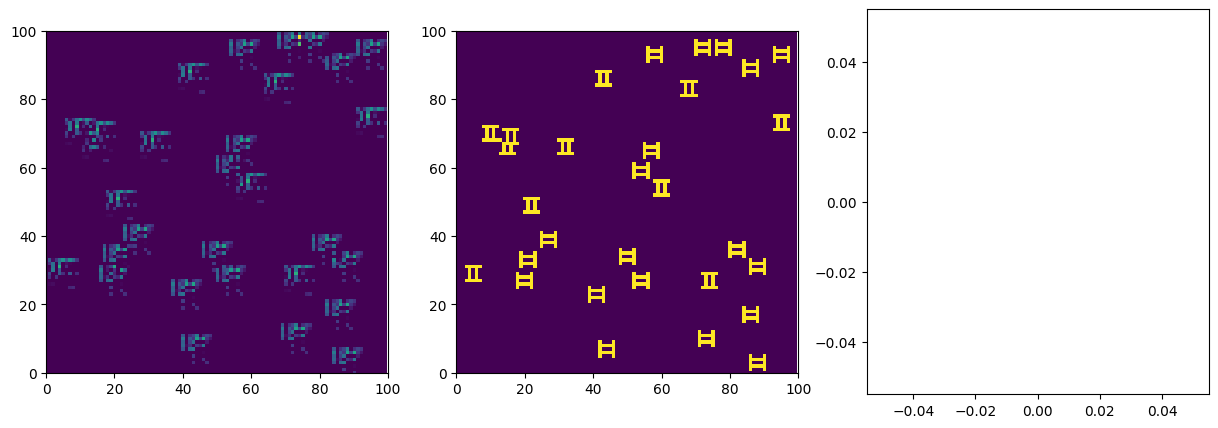

In [ ]:
trainer = ConvTrainer(
    model,
    loss_function,
    optimizer
)
trainer.visualize(im,im)

In [ ]:
trainer.stepes_on_one_img(im,im,n=10)

In [ ]:
trainer.model.conv_1.weight

Parameter containing:
tensor([[[[ 1.0672e-01,  1.4404e-01,  1.0566e-01, -1.6385e-01,  1.8740e-01],
          [-5.8136e-02, -1.5030e-01,  8.8784e-02, -2.6646e-02,  1.0552e-01],
          [-1.6818e-01,  1.2660e-01, -6.5386e-02,  5.9346e-02, -6.3749e-02],
          [-1.0238e-01, -1.8913e-01,  4.8663e-02,  6.5987e-02,  2.3224e-02],
          [-9.6299e-03,  9.6994e-02,  1.3359e-04, -1.4404e-01, -4.7462e-02]]]],
       requires_grad=True)

In [ ]:
trainer.loss_list

[0.04517277330160141,
 0.04492088034749031,
 0.04464373365044594,
 0.044357359409332275,
 0.04405345022678375,
 0.04375958815217018,
 0.043470341712236404,
 0.043192461133003235,
 0.04292415454983711,
 0.04266483336687088]